In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import numpy as np
import torch.nn as nn
import os
from torch.linalg import vector_norm
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import norm
import matplotlib.pyplot as plt
import time

In [ ]:
from RegressionL2_Sim_sense import *
from DSR_Sim_dense import *

In [5]:
## data generator

def preanm_simulator(true_function, n, x_lower, x_upper, noise_std, noise_dist, train=True, device=torch.device("cpu"), a=torch.tensor([1.0, 1.2, 1.5]),noise_corr=0):
    """Data simulator for a pre-additive noise model (pre-ANM) with 3-dimensional covariates and noise.

    Args:
        true_function (str, optional): true function g*. Defaults to "softplus". Choices: ["softplus", "square", "log"].
        n (int, optional): sample size. Defaults to 10000.
        x_lower (int, optional): lower bound of the training support. Defaults to 0.
        x_upper (int, optional): upper bound of the training support. Defaults to 2.
        noise_std (int, optional): standard deviation of the noise. Defaults to 1.
        noise_dist (str, optional): noise distribution. Defaults to "gaussian". Choices: ["gaussian", "uniform"].
        train (bool, optional): generate data for training. Defaults to True.
        device (str or torch.device, optional): device. Defaults to torch.device("cpu").
        a (torch.Tensor, optional): a linear vector to transform input. Defaults to torch.tensor([1,0.4,0.3]).
        noise_corr (float, optional): pairwise correlation between noise components. Defaults to 0.

    Returns:
        tuple of torch.Tensors: data simulated from a pre-ANM.
    """

    if isinstance(true_function, str):
        if true_function == "softplus":
            true_function = lambda x: nn.Softplus()(x)
        elif true_function == "square":
            true_function = lambda x: (nn.functional.relu(x)).pow(2)/7.4
        elif true_function == "log":
            true_function = lambda x: (x/3 + np.log(3) - 2/3)*(x <= 2) + (torch.log(1 + x*(x > 2)))*(x > 2)
        elif true_function == "cubic":
            true_function = lambda x: x.pow(3)/11.1

    if isinstance(device, str):
        device = torch.device(device)


    if a is None:
        a = torch.ones(3)
    a = a.to(device)

    def generate_correlated_noise(n_samples, dim, noise_dist, noise_std, noise_corr):
        cov_matrix = (1/(2.45 + 4.84*noise_corr)) * noise_std**2 * ((1 - noise_corr) * torch.eye(dim) + noise_corr * torch.ones(dim, dim))
        L = torch.linalg.cholesky(cov_matrix)
        z = torch.randn(n_samples, dim, device=device)
        ERR = z @ L.T
        if noise_dist == "gaussian":
            eps = ERR
        else:
            eps = torch.distributions.Normal(0, 1).cdf(ERR) - 0.5 ## transfer such that the noise is distributed as Unif(-0.5,0.5)
            eps = eps * np.sqrt(12)
        return eps

    if train:
        x = torch.rand(n, 3)*(x_upper - x_lower) + x_lower

        # Generate 3-dimensional noise 'eps'
        if noise_dist == "gaussian":
            eps = generate_correlated_noise(n, 3, "gaussian", noise_std, noise_corr)
        else:
            assert noise_dist == "uniform"
            eps = generate_correlated_noise(n, 3, "uniform", noise_std, noise_corr)

        xn = x + eps

        s = xn @ a.unsqueeze(1)

        y = true_function(s)

        return x.to(device), y.to(device)

    else:

        x_eval = torch.linspace(x_lower, x_upper, n).unsqueeze(1).repeat(1, 3)

        s_eval = x_eval @ a.unsqueeze(1)

        y_eval_med = true_function(s_eval)

        gen_sample_size = 10000

        x_rep = torch.repeat_interleave(x_eval, gen_sample_size, dim=0)

        if noise_dist == "gaussian":
            eps = generate_correlated_noise(x_rep.size(0), 3, "gaussian", noise_std, noise_corr)
        else:
            assert noise_dist == "uniform"
            eps = generate_correlated_noise(x_rep.size(0), 3, "uniform", noise_std, noise_corr)

        xn_rep = x_rep + eps
        s_rep = xn_rep @ a.unsqueeze(1)

        y_rep = true_function(s_rep)
        y_eval_mean = y_rep.view(n, gen_sample_size).mean(dim=1).unsqueeze(1)

        return x_eval.to(device), y_eval_med.to(device), y_eval_mean.to(device)

In [ ]:
def run_dsr_simulations(
    N_sim,
    x_min, x_max, num_points,
    n_train, x_lower, x_upper, noise_std,
    lr, num_epochs, batch_size,
    true_function, noise_dist, noise_corr,
    sample_size=512,device='cpu',sigmoid=False
):
    # Arrays to store results
    predicted_means = []
    predicted_medians = []
    predicted_gs_mean = []
    predicted_gs_median = []
    weight_estimates = []

    # Set the seed
    torch_seed = 42
    torch.manual_seed(torch_seed)
    np.random.seed(torch_seed)

    x_eval, y_eval_med, y_eval_mean = preanm_simulator(true_function=true_function, n=num_points,
                                                   x_lower=x_min, x_upper=x_max, noise_std=noise_std, noise_dist=noise_dist,
                                                   train=False, noise_corr=noise_corr,device=device)

    y_true_med = y_eval_med.cpu().numpy()
    y_true_mean = y_eval_mean.cpu().numpy()

    a1 = torch.tensor([1.0, 1.2, 1.5])
    x_test_1d = x_eval @ a1.unsqueeze(1)

    # Run simulations
    for sim in range(N_sim):

        print(f"\nRunning simulation {sim + 1}/{N_sim}")

        torch_seed = sim
        torch.manual_seed(torch_seed)
        np.random.seed(torch_seed)

        # Generate training data
        x_train, y_train = preanm_simulator(
            true_function=true_function,
            n=n_train, x_lower=x_lower, x_upper=x_upper,
            noise_std=noise_std, noise_dist=noise_dist,
            train=True, noise_corr=noise_corr, device=device
        )

        #debug
        #x_train_example = x_train @ a1.unsqueeze(1)
        #y_train_example = y_train
        #plt.figure()
        #plt.scatter(x_train_example, y_train_example, label="Training Data", s=1, color="silver")
        #plt.xlim(0, 5)
        #plt.show()
        # Add a short delay to visualize the updates
        #time.sleep(1)

        # Instantiate and train the DSR model
        DSR = dsr_dense(
            x_train, y_train, lr=lr, num_epochs=num_epochs,
            batch_size=batch_size, device=device, sigmoid=sigmoid
        )

        learned_weight_vector = DSR.get_weight_vector()
        print("Learned weight vector:", learned_weight_vector)

        # Move x_grid to the appropriate device
        x_eval = x_eval.to(DSR.device)

        # Predict mean and median
        y_pred_mean = DSR.predict(x_eval, target="mean", sample_size=sample_size).cpu().numpy()
        y_pred_median = DSR.predict(x_eval, target="median", sample_size=sample_size).cpu().numpy()
        g_pred_mean = DSR.predict_g(x_eval, target="mean", sample_size=sample_size).cpu().numpy()
        g_pred_median = DSR.predict_g(x_eval, target="median", sample_size=sample_size).cpu().numpy()

        # Store results
        predicted_means.append(y_pred_mean)
        predicted_medians.append(y_pred_median)
        predicted_gs_mean.append(g_pred_mean)
        predicted_gs_median.append(g_pred_median)
        weight_estimates.append(learned_weight_vector)


    # Convert lists to NumPy arrays
    predicted_means = np.array(predicted_means)
    predicted_medians = np.array(predicted_medians)
    predicted_gs_mean = np.array(predicted_gs_mean)
    predicted_gs_median = np.array(predicted_gs_median)
    weight_estimates = np.array(weight_estimates)

    x_train_example = x_train @ a1.unsqueeze(1)
    y_train_example = y_train

    # Return results in a dictionary
    results = {
        'predicted_means': predicted_means,
        'predicted_medians': predicted_medians,
        'predicted_funs_mean': predicted_gs_mean,
        'predicted_funs_median': predicted_gs_median,
        'weight_estimates': weight_estimates,
        # Include for plotting
        'x_train': x_train_example,
        'y_train': y_train_example,
        'x_test': x_test_1d,
        'y_true_mean': y_true_mean,
        'y_true_med': y_true_med
    }

    return results



Running simulation 1/20


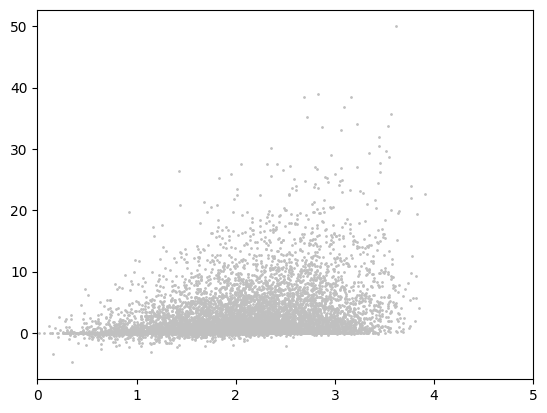

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2748,  E(|Y-Yhat|): 2.4096,  E(|Yhat-Yhat'|): 0.2695
[Epoch 100 (50%)] energy-loss: 1.6646,  E(|Y-Yhat|): 3.1877,  E(|Yhat-Yhat'|): 3.0463
[Epoch 200 (100%)] energy-loss: 1.6093,  E(|Y-Yhat|): 3.1770,  E(|Yhat-Yhat'|): 3.1355

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6126,  E(|Y-Yhat|): 3.1741,  E(|Yhat-Yhat'|): 3.1230

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2858903 1.5238109]

Running simulation 2/20


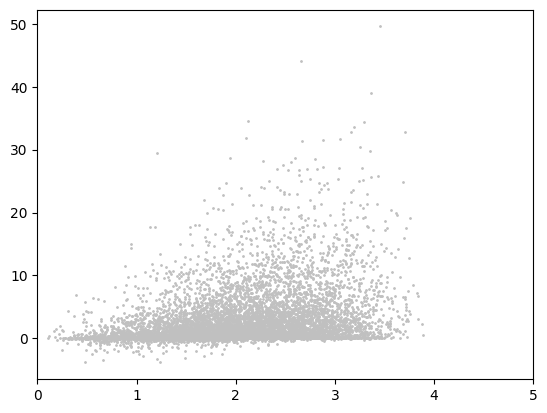

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2890,  E(|Y-Yhat|): 2.3805,  E(|Yhat-Yhat'|): 0.1830
[Epoch 100 (50%)] energy-loss: 1.5848,  E(|Y-Yhat|): 3.1083,  E(|Yhat-Yhat'|): 3.0469
[Epoch 200 (100%)] energy-loss: 1.6098,  E(|Y-Yhat|): 3.1832,  E(|Yhat-Yhat'|): 3.1468

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6094,  E(|Y-Yhat|): 3.2592,  E(|Yhat-Yhat'|): 3.2996

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.140092  1.4573596]

Running simulation 3/20


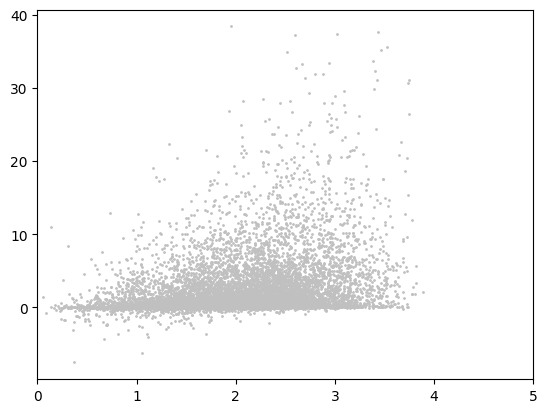

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.1790,  E(|Y-Yhat|): 2.3307,  E(|Yhat-Yhat'|): 0.3034
[Epoch 100 (50%)] energy-loss: 1.6097,  E(|Y-Yhat|): 3.1123,  E(|Yhat-Yhat'|): 3.0051
[Epoch 200 (100%)] energy-loss: 1.6000,  E(|Y-Yhat|): 3.1331,  E(|Yhat-Yhat'|): 3.0663

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6222,  E(|Y-Yhat|): 3.1885,  E(|Yhat-Yhat'|): 3.1326

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.332373  1.6864144]

Running simulation 4/20


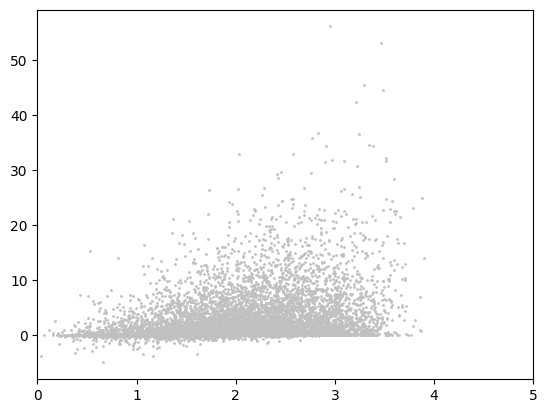

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3127,  E(|Y-Yhat|): 2.4394,  E(|Yhat-Yhat'|): 0.2534
[Epoch 100 (50%)] energy-loss: 1.6613,  E(|Y-Yhat|): 3.2514,  E(|Yhat-Yhat'|): 3.1802
[Epoch 200 (100%)] energy-loss: 1.7093,  E(|Y-Yhat|): 3.3287,  E(|Yhat-Yhat'|): 3.2388

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6963,  E(|Y-Yhat|): 3.3205,  E(|Yhat-Yhat'|): 3.2484

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.3369957 1.6923465]

Running simulation 5/20


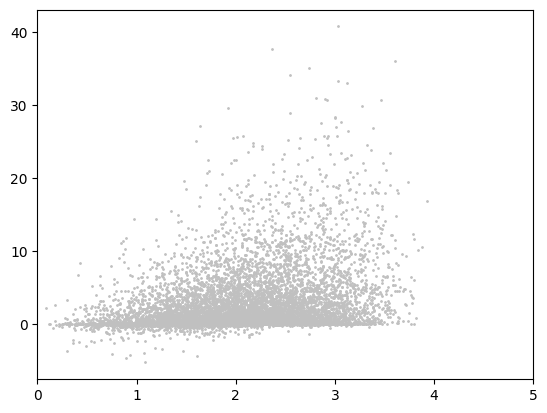

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3978,  E(|Y-Yhat|): 2.4228,  E(|Yhat-Yhat'|): 0.0501
[Epoch 100 (50%)] energy-loss: 1.6145,  E(|Y-Yhat|): 3.1400,  E(|Yhat-Yhat'|): 3.0510
[Epoch 200 (100%)] energy-loss: 1.5941,  E(|Y-Yhat|): 3.1592,  E(|Yhat-Yhat'|): 3.1300

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.5995,  E(|Y-Yhat|): 3.2120,  E(|Yhat-Yhat'|): 3.2249

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.129594  1.4392159]

Running simulation 6/20


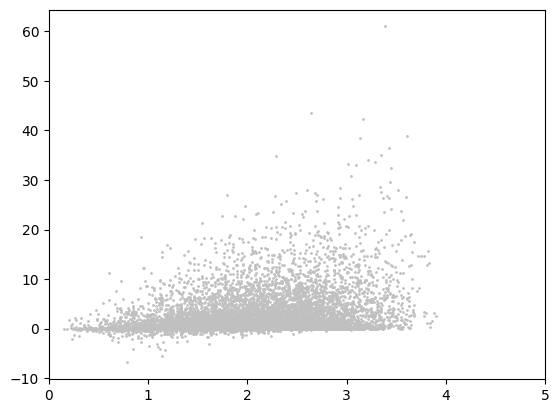

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3681,  E(|Y-Yhat|): 2.4003,  E(|Yhat-Yhat'|): 0.0644
[Epoch 100 (50%)] energy-loss: 1.6494,  E(|Y-Yhat|): 3.1820,  E(|Yhat-Yhat'|): 3.0652
[Epoch 200 (100%)] energy-loss: 1.6155,  E(|Y-Yhat|): 3.1550,  E(|Yhat-Yhat'|): 3.0789

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.5884,  E(|Y-Yhat|): 3.1400,  E(|Yhat-Yhat'|): 3.1033

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1874393 1.5020024]

Running simulation 7/20


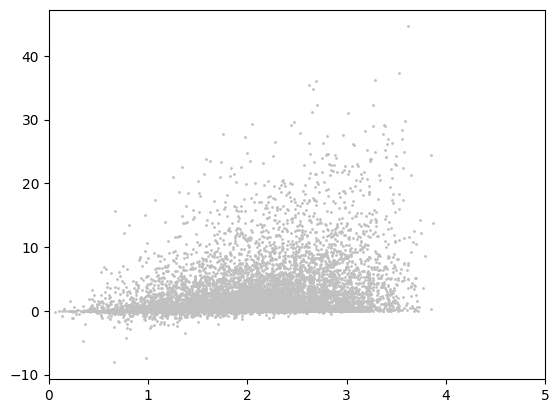

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2789,  E(|Y-Yhat|): 2.4272,  E(|Yhat-Yhat'|): 0.2967
[Epoch 100 (50%)] energy-loss: 1.6720,  E(|Y-Yhat|): 3.2530,  E(|Yhat-Yhat'|): 3.1620
[Epoch 200 (100%)] energy-loss: 1.6847,  E(|Y-Yhat|): 3.2661,  E(|Yhat-Yhat'|): 3.1627

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6467,  E(|Y-Yhat|): 3.2374,  E(|Yhat-Yhat'|): 3.1814

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2308658 1.6362445]

Running simulation 8/20


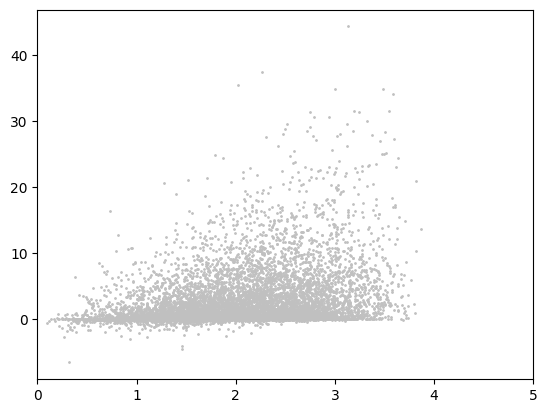

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3540,  E(|Y-Yhat|): 2.4094,  E(|Yhat-Yhat'|): 0.1109
[Epoch 100 (50%)] energy-loss: 1.6140,  E(|Y-Yhat|): 3.1653,  E(|Yhat-Yhat'|): 3.1027
[Epoch 200 (100%)] energy-loss: 1.6299,  E(|Y-Yhat|): 3.1860,  E(|Yhat-Yhat'|): 3.1121

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6301,  E(|Y-Yhat|): 3.2046,  E(|Yhat-Yhat'|): 3.1490

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1472504 1.3593782]

Running simulation 9/20


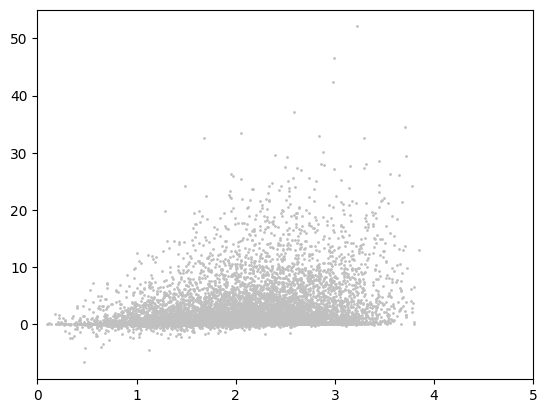

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3146,  E(|Y-Yhat|): 2.3889,  E(|Yhat-Yhat'|): 0.1485
[Epoch 100 (50%)] energy-loss: 1.6143,  E(|Y-Yhat|): 3.1755,  E(|Yhat-Yhat'|): 3.1224
[Epoch 200 (100%)] energy-loss: 1.6292,  E(|Y-Yhat|): 3.1938,  E(|Yhat-Yhat'|): 3.1292

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6078,  E(|Y-Yhat|): 3.2527,  E(|Yhat-Yhat'|): 3.2896

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2774196 1.5417892]

Running simulation 10/20


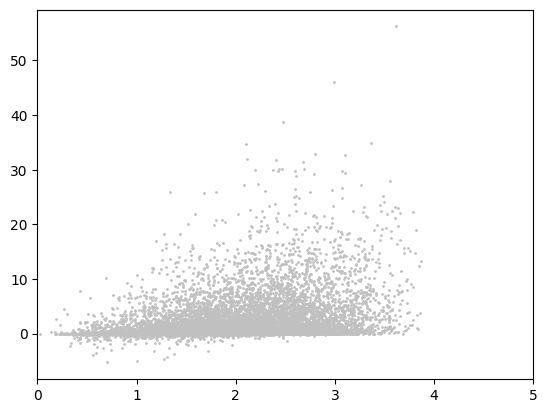

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3663,  E(|Y-Yhat|): 2.4377,  E(|Yhat-Yhat'|): 0.1429
[Epoch 100 (50%)] energy-loss: 1.6364,  E(|Y-Yhat|): 3.1677,  E(|Yhat-Yhat'|): 3.0626
[Epoch 200 (100%)] energy-loss: 1.6410,  E(|Y-Yhat|): 3.2093,  E(|Yhat-Yhat'|): 3.1367

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6006,  E(|Y-Yhat|): 3.2396,  E(|Yhat-Yhat'|): 3.2779

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1642636 1.5490781]

Running simulation 11/20


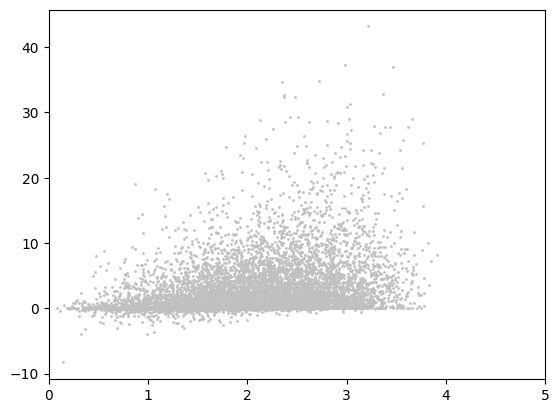

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2656,  E(|Y-Yhat|): 2.3848,  E(|Yhat-Yhat'|): 0.2383
[Epoch 100 (50%)] energy-loss: 1.6185,  E(|Y-Yhat|): 3.1483,  E(|Yhat-Yhat'|): 3.0594
[Epoch 200 (100%)] energy-loss: 1.6246,  E(|Y-Yhat|): 3.1914,  E(|Yhat-Yhat'|): 3.1335

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6040,  E(|Y-Yhat|): 3.2100,  E(|Yhat-Yhat'|): 3.2121

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.4035529 1.6377025]

Running simulation 12/20


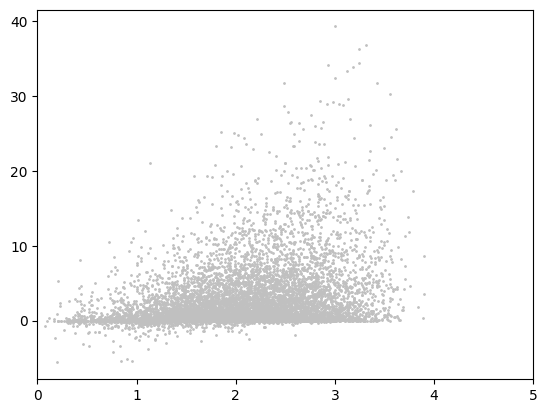

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3583,  E(|Y-Yhat|): 2.3816,  E(|Yhat-Yhat'|): 0.0466
[Epoch 100 (50%)] energy-loss: 1.5801,  E(|Y-Yhat|): 3.0814,  E(|Yhat-Yhat'|): 3.0026
[Epoch 200 (100%)] energy-loss: 1.5886,  E(|Y-Yhat|): 3.1364,  E(|Yhat-Yhat'|): 3.0956

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6043,  E(|Y-Yhat|): 3.1132,  E(|Yhat-Yhat'|): 3.0177

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1668792 1.4573954]

Running simulation 13/20


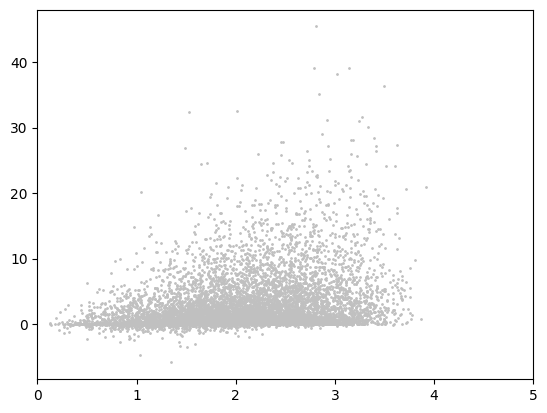

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3538,  E(|Y-Yhat|): 2.3956,  E(|Yhat-Yhat'|): 0.0836
[Epoch 100 (50%)] energy-loss: 1.6001,  E(|Y-Yhat|): 3.1824,  E(|Yhat-Yhat'|): 3.1646
[Epoch 200 (100%)] energy-loss: 1.6064,  E(|Y-Yhat|): 3.1654,  E(|Yhat-Yhat'|): 3.1180

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6267,  E(|Y-Yhat|): 3.2261,  E(|Yhat-Yhat'|): 3.1987

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1473589 1.4182681]

Running simulation 14/20


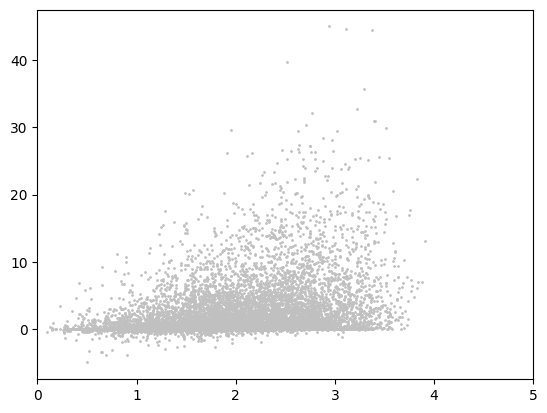

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.4424,  E(|Y-Yhat|): 2.4515,  E(|Yhat-Yhat'|): 0.0182
[Epoch 100 (50%)] energy-loss: 1.6022,  E(|Y-Yhat|): 3.1316,  E(|Yhat-Yhat'|): 3.0589
[Epoch 200 (100%)] energy-loss: 1.6271,  E(|Y-Yhat|): 3.1573,  E(|Yhat-Yhat'|): 3.0605

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6182,  E(|Y-Yhat|): 3.1462,  E(|Yhat-Yhat'|): 3.0560

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2219903 1.4405842]

Running simulation 15/20


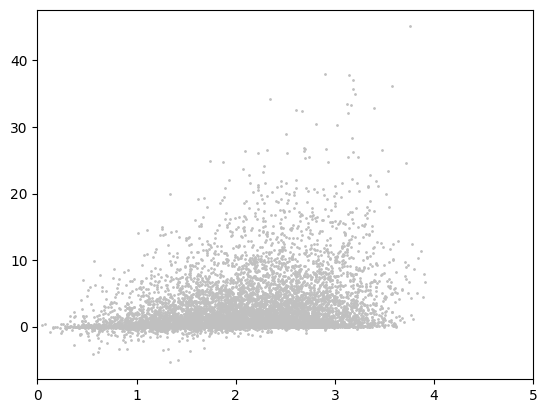

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2527,  E(|Y-Yhat|): 2.3341,  E(|Yhat-Yhat'|): 0.1628
[Epoch 100 (50%)] energy-loss: 1.5793,  E(|Y-Yhat|): 3.0770,  E(|Yhat-Yhat'|): 2.9954
[Epoch 200 (100%)] energy-loss: 1.5717,  E(|Y-Yhat|): 3.0889,  E(|Yhat-Yhat'|): 3.0343

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.5810,  E(|Y-Yhat|): 3.1284,  E(|Yhat-Yhat'|): 3.0948

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2526035 1.666212 ]

Running simulation 16/20


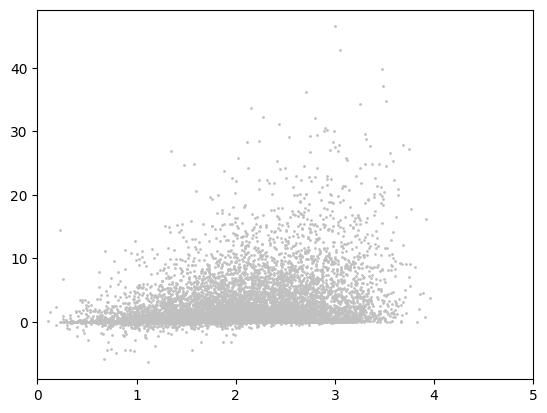

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3712,  E(|Y-Yhat|): 2.4094,  E(|Yhat-Yhat'|): 0.0765
[Epoch 100 (50%)] energy-loss: 1.5923,  E(|Y-Yhat|): 3.1103,  E(|Yhat-Yhat'|): 3.0359
[Epoch 200 (100%)] energy-loss: 1.5996,  E(|Y-Yhat|): 3.1555,  E(|Yhat-Yhat'|): 3.1118

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6126,  E(|Y-Yhat|): 3.1829,  E(|Yhat-Yhat'|): 3.1406

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.0842382 1.5378001]

Running simulation 17/20


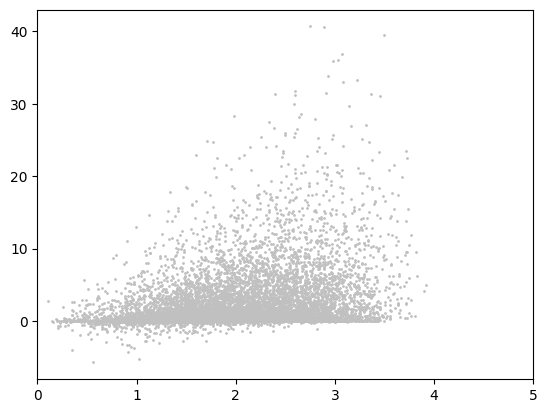

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2607,  E(|Y-Yhat|): 2.3499,  E(|Yhat-Yhat'|): 0.1785
[Epoch 100 (50%)] energy-loss: 1.5663,  E(|Y-Yhat|): 3.1007,  E(|Yhat-Yhat'|): 3.0687
[Epoch 200 (100%)] energy-loss: 1.5924,  E(|Y-Yhat|): 3.1470,  E(|Yhat-Yhat'|): 3.1090

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.5919,  E(|Y-Yhat|): 3.2138,  E(|Yhat-Yhat'|): 3.2438

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1933783 1.5304184]

Running simulation 18/20


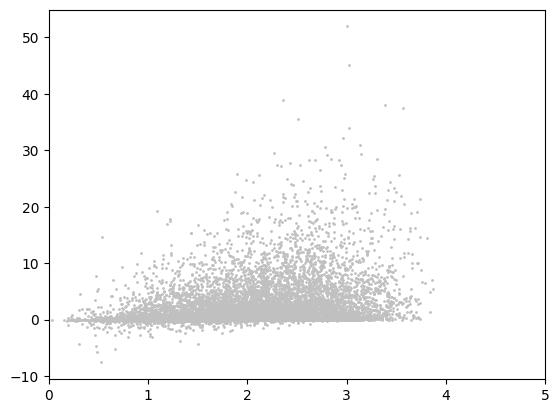

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.3050,  E(|Y-Yhat|): 2.3875,  E(|Yhat-Yhat'|): 0.1650
[Epoch 100 (50%)] energy-loss: 1.5969,  E(|Y-Yhat|): 3.1154,  E(|Yhat-Yhat'|): 3.0370
[Epoch 200 (100%)] energy-loss: 1.6178,  E(|Y-Yhat|): 3.1677,  E(|Yhat-Yhat'|): 3.0998

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6015,  E(|Y-Yhat|): 3.1784,  E(|Yhat-Yhat'|): 3.1538

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.3532917 1.4350786]

Running simulation 19/20


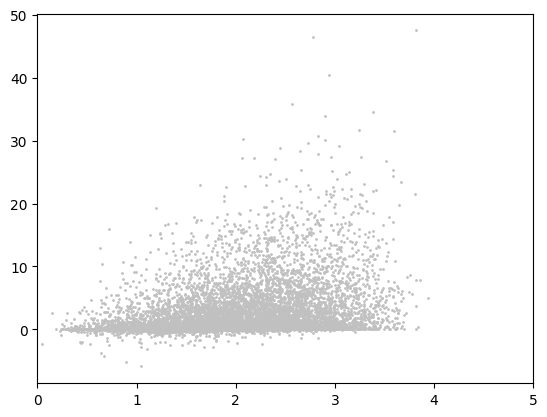

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.2933,  E(|Y-Yhat|): 2.3981,  E(|Yhat-Yhat'|): 0.2097
[Epoch 100 (50%)] energy-loss: 1.6447,  E(|Y-Yhat|): 3.2044,  E(|Yhat-Yhat'|): 3.1194
[Epoch 200 (100%)] energy-loss: 1.6267,  E(|Y-Yhat|): 3.1749,  E(|Yhat-Yhat'|): 3.0965

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6372,  E(|Y-Yhat|): 3.1728,  E(|Yhat-Yhat'|): 3.0712

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.2807337 1.4517918]

Running simulation 20/20


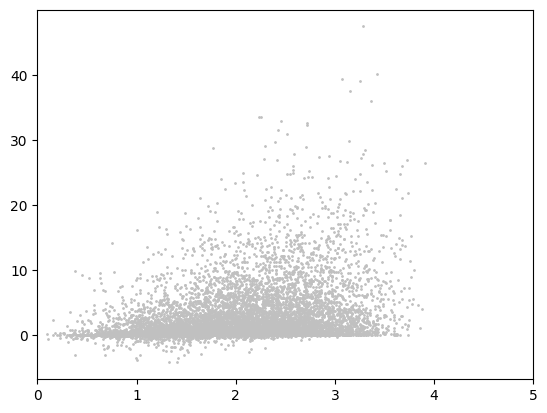

Running on CPU.

Data is standardized for training only; the printed training losses are on the standardized scale. 
However during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 2.4572,  E(|Y-Yhat|): 2.4749,  E(|Yhat-Yhat'|): 0.0354
[Epoch 100 (50%)] energy-loss: 1.6570,  E(|Y-Yhat|): 3.2778,  E(|Yhat-Yhat'|): 3.2417
[Epoch 200 (100%)] energy-loss: 1.6757,  E(|Y-Yhat|): 3.2971,  E(|Yhat-Yhat'|): 3.2428

Training loss on the original (non-standardized) scale:
	Energy-loss: 1.6602,  E(|Y-Yhat|): 3.3202,  E(|Yhat-Yhat'|): 3.3199

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 
Learned weight vector: [1.        1.1064793 1.4226475]


In [ ]:
N_sim = 20
x_min = 0
x_max = 1.64
x_lower = 0
x_upper = 1.08
true_function = "cubic"  # ["square", "softplus","cubic","log"]
#noise_dist = "gaussian"
noise_dist = "uniform"
noise_correlation = 0
num_epochs = 200
n_train = 10000
num_points = 10000
noise_std = 1
lr = 0.005
batch_size=5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run simulations with the specified parameters
results1 = run_dsr_simulations(
    N_sim=N_sim, x_min=x_min, x_max=x_max,
    x_lower=x_lower,x_upper=x_upper,
    true_function=true_function,
    n_train=n_train,
    noise_dist=noise_dist,
    noise_corr=noise_correlation,
    num_epochs=num_epochs,
    num_points=num_points,
    noise_std = noise_std,
    batch_size = batch_size,
    device=device,lr=lr
)

In [ ]:
np.savez("~/simresults1_DSR_cubic2.npz", results_cubic2=results1)

In [ ]:
def run_compare_simulations(
    N_sim,
    x_min, x_max, num_points,
    n_train, x_lower, x_upper, noise_std,
    lr, num_epochs, batch_size,
    true_function, noise_dist, noise_corr=0, device="cpu"
):
    """
    Run multiple L2 simulations and store results.
    """
    # Arrays to store results
    predicted_means = []
    L2_errors = []
    weight_estimates = []
    predicted_gs = []

    # Set the seed
    torch_seed = 42
    torch.manual_seed(torch_seed)
    np.random.seed(torch_seed)


    ## truth for comparison
    x_eval, y_eval_med, y_eval_mean = preanm_simulator(true_function=true_function, n=num_points,
                                                       x_lower=x_min, x_upper=x_max, noise_std=noise_std, noise_dist=noise_dist,
                                                       train=False, noise_corr=noise_corr, device=device)

    y_true_mean = y_eval_mean.cpu().numpy()


    a1 = torch.tensor([1, 1.2, 1.5])
    x_test_1d = x_eval @ a1.unsqueeze(1)


    # Run simulations
    for sim in range(N_sim):
        print(f"\nRunning simulation {sim + 1}/{N_sim}")

        torch_seed = sim
        torch.manual_seed(torch_seed)
        np.random.seed(torch_seed)


        # Generate training data
        x_train, y_train = preanm_simulator(
            true_function=true_function,
            n=n_train, x_lower=x_lower, x_upper=x_upper,
            noise_std=noise_std, noise_dist=noise_dist,
            train=True, noise_corr=noise_corr, device=device
        )

        #debug
        x_train_example = x_train @ a1.unsqueeze(1)
        y_train_example = y_train
        plt.figure()
        plt.scatter(x_train_example, y_train_example, label="Training Data", s=1, color="silver")
        plt.xlim(0, 5)
        plt.show()
        # Add a short delay to visualize the updates
        time.sleep(1)


        model = MyNet(
        in_dim=3,
        out_dim=1,
        num_layer=3,
        hidden_dim=100,
        add_bn=True,
        sigmoid=False
        )

        train_model(
        model=model,
        X_train=x_train,
        y_train=y_train,
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=lr,
        device=device
        )

        y_pred_mean = predict_model(model, x_eval, device)  ## using beta_hat
        g_pred = predict_g(model, x_eval, device)  ## using true beta

        mse_loss = nn.MSELoss()
        L2_error = mse_loss(y_pred_mean, y_eval_mean)

        # Retrieve the weight vector
        weight_vector = model.get_weight_vector()
        print("Learned weight vector:", weight_vector)


        # Store results
        predicted_means.append(y_pred_mean)
        L2_errors.append(L2_error)
        weight_estimates.append(weight_vector)
        predicted_gs.append(g_pred)

    # Convert lists to NumPy arrays
    predicted_means = np.array(predicted_means)
    L2_errors = np.array(L2_errors)
    weight_estimates = np.array(weight_estimates)
    predicted_gs = np.array(predicted_gs)

    x_train_example = x_train @ a1.unsqueeze(1)
    y_train_example = y_train

    # Return results in a dictionary
    results = {
        'predicted_means': predicted_means,
        'predicted_funs': predicted_gs,
        'L2_errors': L2_errors,
        'weight_estimates': weight_estimates,
        # Include for plotting
        'x_train': x_train_example,
        'y_train': y_train_example,
        'x_test': x_test_1d,
        'y_true_mean': y_true_mean
    }

    return results


Running simulation 1/20


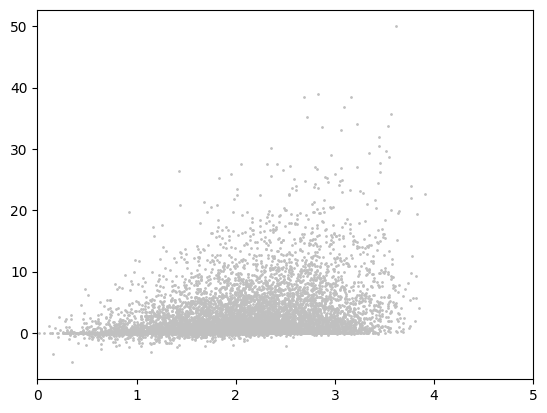

Epoch 100/200, Loss: 14.677493
Epoch 200/200, Loss: 14.678486
Learned weight vector: [1.        1.5851189 1.7832818]

Running simulation 2/20


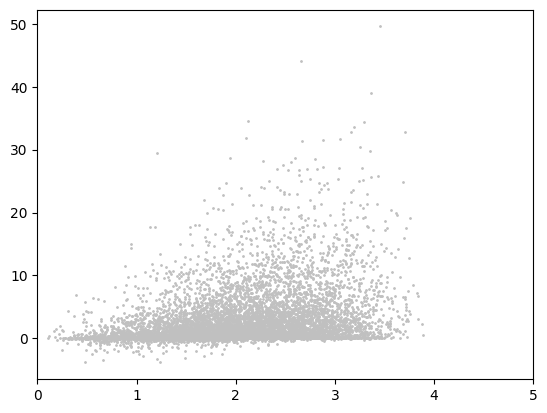

Epoch 100/200, Loss: 14.893425
Epoch 200/200, Loss: 14.826489
Learned weight vector: [1.        1.3608898 1.7392663]

Running simulation 3/20


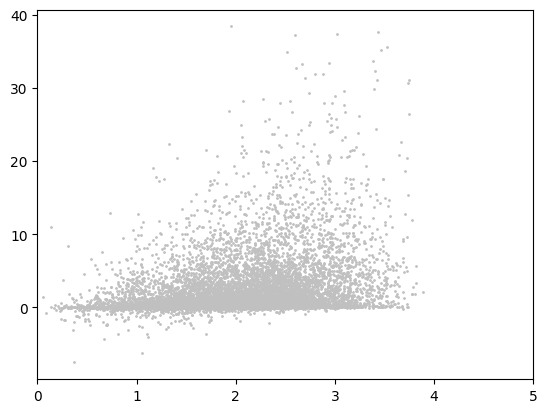

Epoch 100/200, Loss: 14.837903
Epoch 200/200, Loss: 14.820695
Learned weight vector: [1.        1.5405192 2.0367188]

Running simulation 4/20


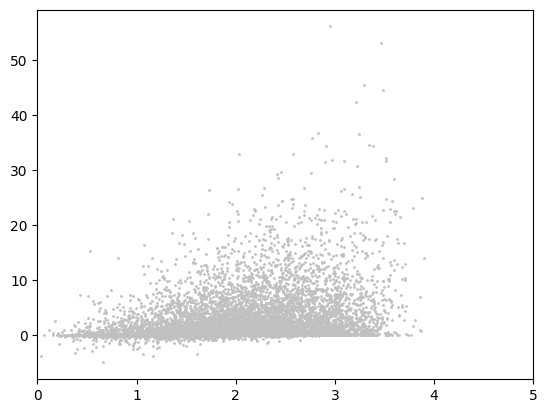

Epoch 100/200, Loss: 16.055991
Epoch 200/200, Loss: 16.018875
Learned weight vector: [1.        1.582297  1.9493732]

Running simulation 5/20


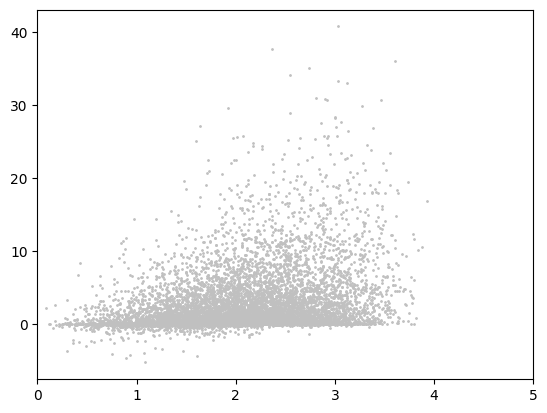

Epoch 100/200, Loss: 14.308624
Epoch 200/200, Loss: 14.254129
Learned weight vector: [1.        1.274202  1.5950955]

Running simulation 6/20


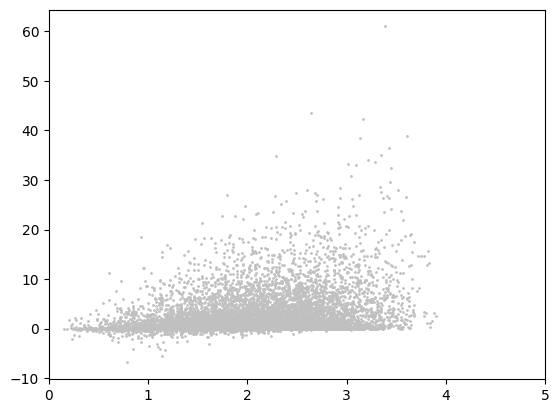

Epoch 100/200, Loss: 14.699507
Epoch 200/200, Loss: 14.701802
Learned weight vector: [1.        1.3498424 1.7266408]

Running simulation 7/20


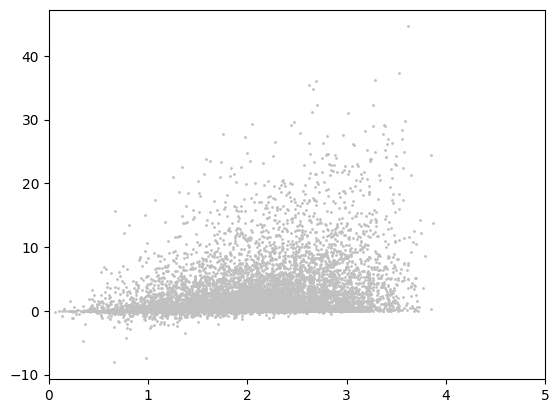

Epoch 100/200, Loss: 15.679292
Epoch 200/200, Loss: 15.564447
Learned weight vector: [1.        1.4344568 1.9755676]

Running simulation 8/20


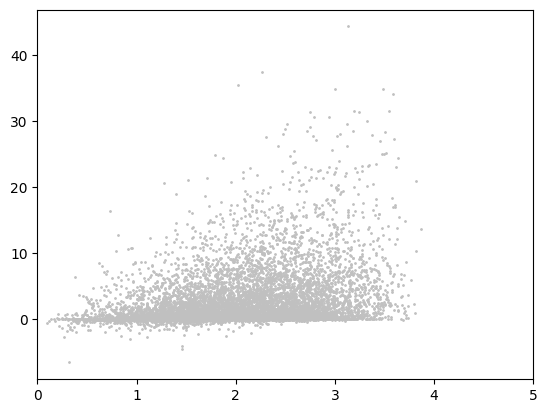

Epoch 100/200, Loss: 14.668866
Epoch 200/200, Loss: 14.582232
Learned weight vector: [1.        1.3335168 1.6185246]

Running simulation 9/20


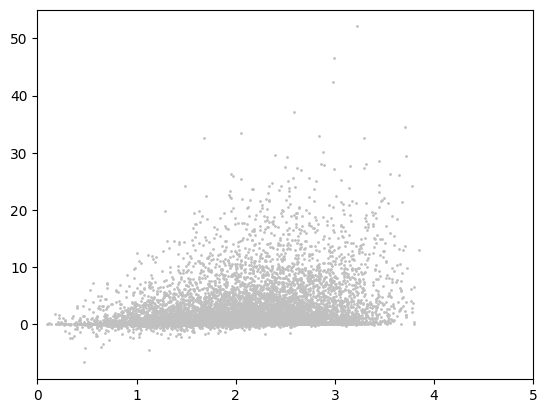

Epoch 100/200, Loss: 15.203444
Epoch 200/200, Loss: 15.174725
Learned weight vector: [1.        1.4796526 1.7761103]

Running simulation 10/20


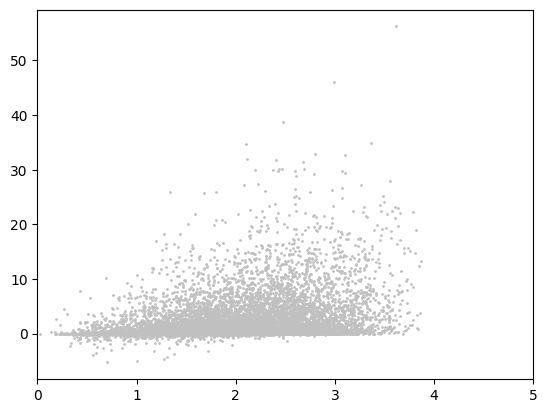

Epoch 100/200, Loss: 14.977627
Epoch 200/200, Loss: 14.874601
Learned weight vector: [1.        1.3781874 1.8685349]

Running simulation 11/20


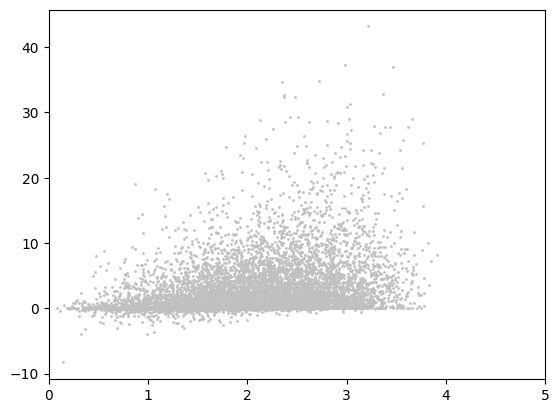

Epoch 100/200, Loss: 14.539174
Epoch 200/200, Loss: 14.512538
Learned weight vector: [1.        1.6880925 1.900495 ]

Running simulation 12/20


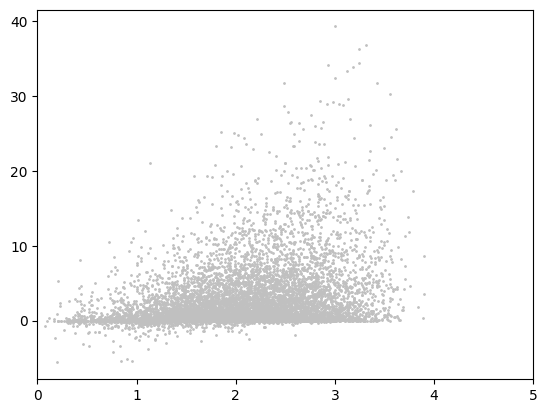

Epoch 100/200, Loss: 13.976211
Epoch 200/200, Loss: 13.851607
Learned weight vector: [1.        1.3740463 1.7468272]

Running simulation 13/20


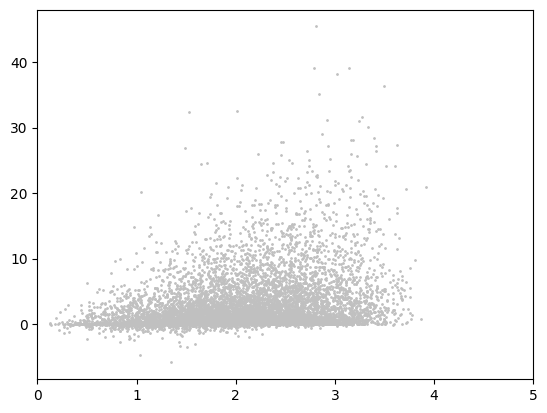

Epoch 100/200, Loss: 14.592257
Epoch 200/200, Loss: 14.551026
Learned weight vector: [1.        1.2922775 1.6616118]

Running simulation 14/20


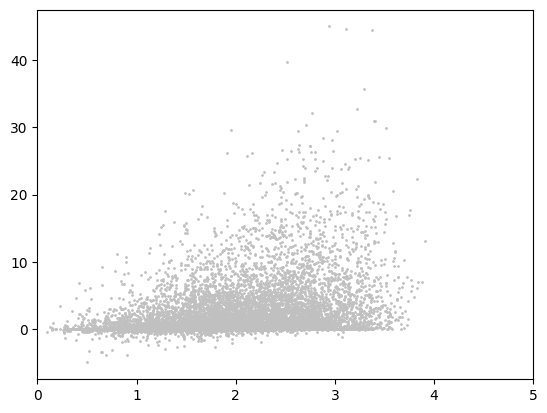

Epoch 100/200, Loss: 14.685485
Epoch 200/200, Loss: 14.671493
Learned weight vector: [1.        1.3310882 1.6665559]

Running simulation 15/20


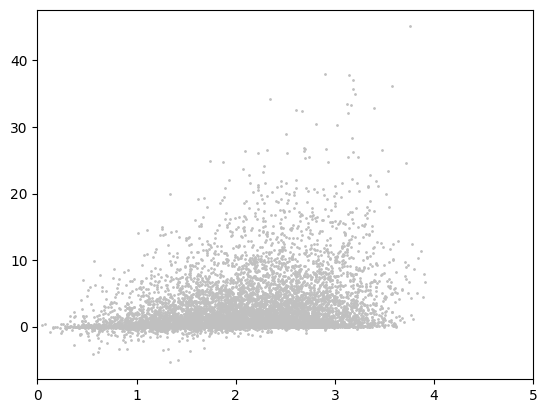

Epoch 100/200, Loss: 13.970861
Epoch 200/200, Loss: 13.916621
Learned weight vector: [1.        1.5278496 1.9847811]

Running simulation 16/20


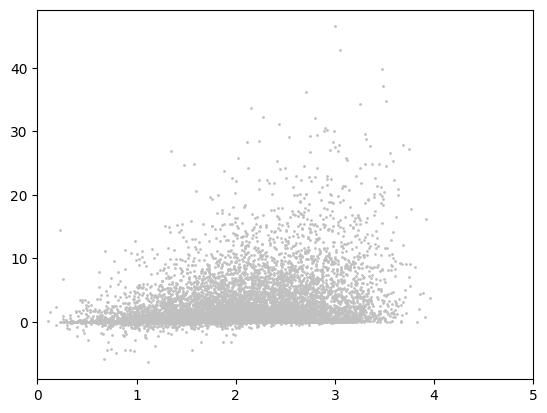

Epoch 100/200, Loss: 14.686373
Epoch 200/200, Loss: 14.627907
Learned weight vector: [1.        1.2481627 1.6784407]

Running simulation 17/20


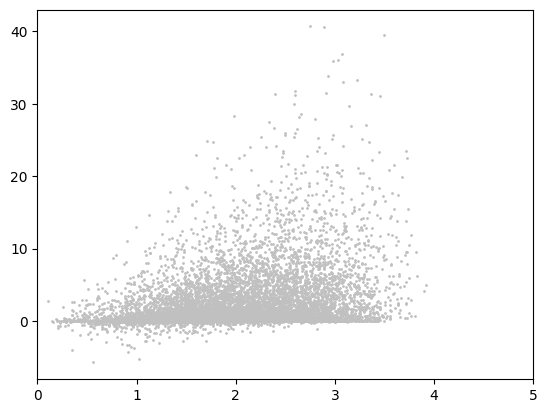

Epoch 100/200, Loss: 14.282948
Epoch 200/200, Loss: 14.243810
Learned weight vector: [1.        1.3894546 1.8499252]

Running simulation 18/20


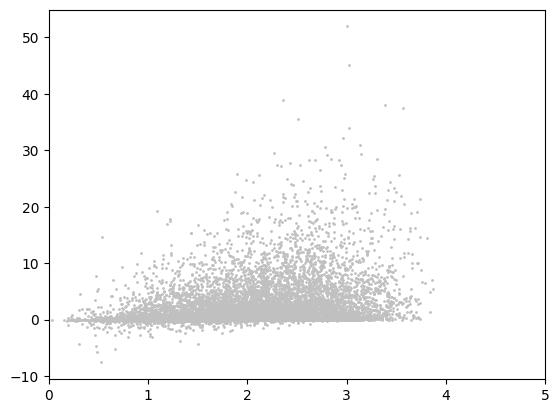

Epoch 100/200, Loss: 14.532270
Epoch 200/200, Loss: 14.506226
Learned weight vector: [1.        1.5944443 1.7344605]

Running simulation 19/20


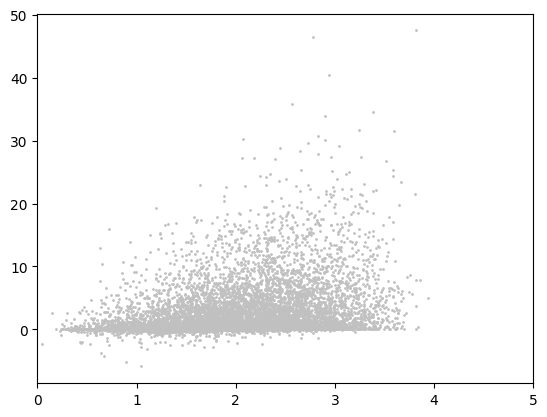

Epoch 100/200, Loss: 14.662802
Epoch 200/200, Loss: 14.594410
Learned weight vector: [1.        1.5708525 1.8173167]

Running simulation 20/20


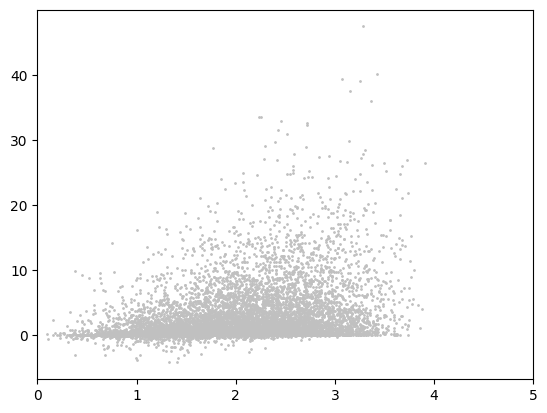

Epoch 100/200, Loss: 15.459126
Epoch 200/200, Loss: 15.454126
Learned weight vector: [1.        1.2330588 1.660711 ]


In [7]:
## example 2: Uniform noise


N_sim = 20
x_min = 0
x_max = 1.64
x_lower = 0
x_upper = 1.08
true_function = "cubic"
#noise_dist = "gaussian"
noise_dist = "uniform"
noise_correlation = 0
num_epochs = 200
n_train = 10000
num_points = 10000
noise_std = 1
lr = 0.005
batch_size=5000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run simulations with the specified parameters
results2_L2 = run_compare_simulations(
    N_sim=N_sim, x_min=x_min, x_max=x_max,
    x_lower=x_lower,x_upper=x_upper,
    true_function=true_function,
    n_train=n_train,
    noise_dist=noise_dist,
    noise_corr=noise_correlation,
    num_epochs=num_epochs,
    num_points=num_points,
    noise_std = noise_std,
    batch_size = batch_size,
    device=device,lr=lr
)

In [ ]:
np.savez("~/simresults1_regression_cubic2.npz", results_cubic2=results2_L2)